In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_formats = ['retina']

import re
import os
import shutil
import numpy as np
import arviz as az
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import autoeis as ae
import glob

from tqdm.auto import tqdm


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
path_eis = "dataset/PJ122/eis-raw/PJ122_002_01_GEIS_CA2.txt"
eis_data = pd.read_csv(path_eis, sep="\t")
freq = eis_data["freq/Hz"].to_numpy()
Z = eis_data["Re(Z)/Ohm"].to_numpy() - 1j * eis_data["-Im(Z)/Ohm"].to_numpy()

path_ecm = "dataset/PJ122/ecm/PJ122_002_01_GEIS_CA2.csv"
circuits = pd.read_csv(path_ecm)
R = ae.core.find_ohmic_resistance(Z, freq)
circuits = ae.core.apply_heuristic_rules(circuits, R)
circuits


,Combined Circuits,Combined Values,Mathematical expressions,Counts,Different value sets,Variables_names,Variables_values
0,"R1-P2-[P3,R4]-[P5,R6]","[[R1 = 0.07646, P2w = 0.12468, P2n = 0.78811, ...",X[0]+(1/(X[1]*(2*1j*np.pi*F)**(X[2])))+(((1/(X...,1,1,"[R1, P2w, P2n, P3w, P3n, R4, P5w, P5n, R6]","[0.07646, 0.12468, 0.78811, 10.111, 0.99999, 1..."


In [18]:
componenets = circuits.iloc[0]["Variables_names"]

states = ["charge", "discharge"]
posterior = {"charge": {}, "discharge": {}}

# Load MCMC traces
path_trace = "PJ121-trace"

for state in states:
    # Create a dictionary for each state and initialize with empty lists
    for component in componenets:
        posterior[state][component] = []
    # Fetch all trace files for the state
    file_list = glob.glob(os.path.join(path_trace, f"{state}/*.nc"))
    file_list.sort()
    # Load each trace file and convert to dataframe
    for fpath in tqdm(file_list, desc=f"Loading {state} traces"): 
        trace = az.from_netcdf(fpath)
        df = trace.to_dataframe('posterior')
        # Populate the posterior dictionary
        for component in componenets:
            posterior[state][component].append(df[component])
    # Convert list of pd.Series to pd.DataFrame and rename columns to trace numbers
    for component in componenets:
        posterior[state][component] = pd.concat(posterior[state][component], axis=1)
        posterior[state][component].columns = range(len(posterior[state][component].columns))


Loading charge traces:   0%|          | 0/65 [00:00<?, ?it/s]

Loading discharge traces:   0%|          | 0/81 [00:00<?, ?it/s]

(0.0, 0.39099812507629395)

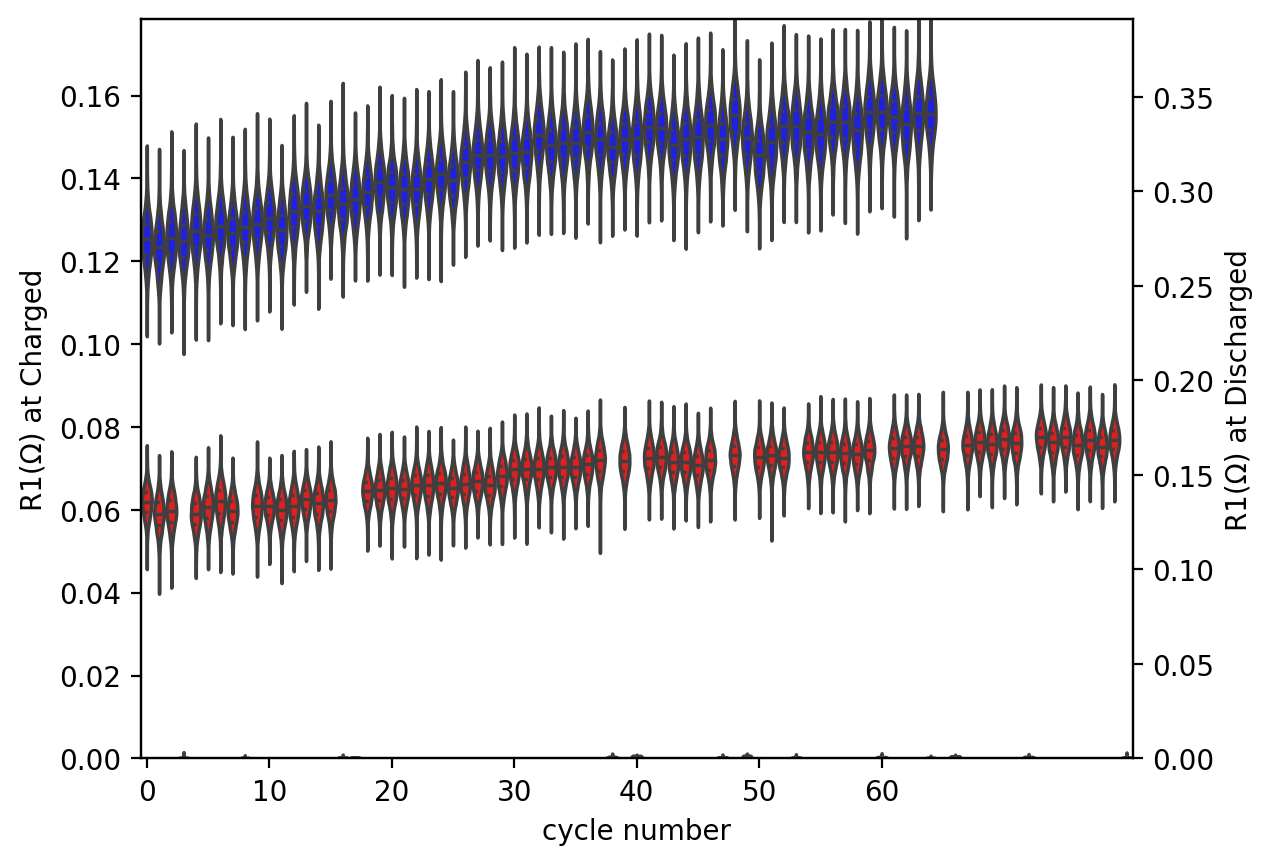

In [20]:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()

component = "R1"

data_charge = posterior["charge"][component]
data_discharge = posterior["discharge"][component]

sns.violinplot(data_charge, inner="quartile", density_norm="count", color="b", ax=ax1)
sns.violinplot(data_discharge, inner="quartile", density_norm="count", color="r", ax=ax2)

# Set xticks to show every 10th tick
num_cycles = len(posterior[states[0]][component].columns)
xtick_locs = np.arange(0, num_cycles+1, 10)
ax1.set_xticks(xtick_locs)

ax1.set_xlabel("cycle number")
ax1.set_ylabel("R1(Ω) at Charged")
ax2.set_ylabel("R1(Ω) at Discharged")

# Set y-axis limits
ax1.set_ylim([0, np.nanmax(data_charge)])
ax2.set_ylim([0, 2*np.nanmax(data_discharge)])

# fig.savefig("temp/R1.png", dpi=300, bbox_inches="tight")
